In [19]:
import pandas as pd
import numpy as np 
import os
from src import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv2
from tqdm import tqdm

In [52]:
def apply_cascade(S_0, features_0, I, cascade, initial_contribution):

    forrest_contribution = initial_contribution
        
    
    x_mask = [x for x in range(0, len(forrest_contribution)-1, 2)]
    y_mask = [x for x in range(1, len(forrest_contribution), 2)]
    
    intensities = I[np.array(features_0[:,1]), np.array(features_0[:,0])]
    
    for tree in cascade:
        forrest_contribution = forrest_contribution + 0.1* get_avarage_residual_vector_for_image(tree, intensities )
    
    S_1 = S_0 + list(zip(forrest_contribution[x_mask], forrest_contribution[y_mask]))
    
    #Calculate means of mean_shape for moving it and its features to origo
    S_0_mean       = np.mean(S_0, axis=0)
    S_0_centered   = S_0 - S_0_mean
    features_0_centered = features_0 - S_0_mean
    
    #Calculate means of s_hat_new for moving it and its features to origo
    S_1_mean = np.mean(S_1, axis=0)
    S_1_centered = S_1 - S_1_mean

    features_1 = transform_features(S_0_centered, S_1_centered, features_0_centered).astype(int)

    #Move features_hat_new back to image's coordinate system
    features_1 += S_1_mean.astype(int)
    
    return features_1, S_1 

In [53]:
annotations_path = 'data/annotation/'

In [54]:
training_data  =  np.load("np_data/run_input_training_data.npy", allow_pickle=True)
t_0            = np.load("saved_while_training/t_data0.npy", allow_pickle=True)
t_1            = np.load("saved_while_training/t_data1.npy", allow_pickle=True)
t_2            = np.load("saved_while_training/t_data2.npy", allow_pickle=True)

406


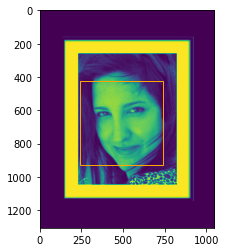

In [55]:
test_names     = get_all_file_names('data/test')
file_name      = test_names[120]
test_image     = cv2.imread("data/test/" +file_name, cv2.IMREAD_GRAYSCALE)
h, w           = test_image.shape
bb             = get_rectangle_bounding_box_for_image("data/test/"+file_name, frontalface_config='default')

bb_w           = bb[2]
bb_scale       = 500 / bb_w
test_image     = cv2.resize(test_image, (int(w*bb_scale), int(h*bb_scale)), interpolation=cv2.INTER_LINEAR)


fig, ax = plt.subplots()


h_pad      = (int((h / 100) * 20))
w_pad      = (int((w / 100) * 20))

print(bb[2])

bb[2] = bb[2] * bb_scale
bb[3] = bb[3] * bb_scale
bb[0] = bb[0] * bb_scale
bb[1] = bb[1] * bb_scale

bb[0]  = bb[0] +w_pad   #bb[0][0] = x coord, bb[0][2] = w
bb[1]  = bb[1] +h_pad  #bb[0][1]  = y coord, bb[0][3] = h


ax.add_patch(Rectangle((bb[0],bb[1]), bb[2], bb[3], ec="orange", fill=None, alpha=1)) 


test_image = cv2.copyMakeBorder(test_image, h_pad, h_pad, w_pad, w_pad, cv2.BORDER_CONSTANT)

ax.imshow(test_image)


In [56]:
annotation_files = get_all_file_names(annotations_path)

image_to_annotation_dict = {}
for file in annotation_files:
    with open(annotations_path+file) as f:
        first_line = f.readline().replace('\n','')
    image_to_annotation_dict[first_line] = file

In [57]:
S_0 = get_mean_shape_from_files(test_names, image_to_annotation_dict,annotations_path)
S_0 = center_shape(S_0)
features_0 = np.load("np_data/mean_shape_features.npy", allow_pickle=True)


In [58]:
#NOTE scalling to bb; We choose to multiply s hat height by some constant to make up for the extra padding the bounding box adds
S_0_height      = np.max(S_0[:,1]) - np.min(S_0[:,1])
scale_value     = bb[3] / (S_0_height *1.3)
S_0             = S_0 *scale_value
features_0      = features_0 *scale_value
S_0            += [bb[0] +  bb[2]/2,bb[1]+bb[3]/2]
features_0     += [bb[0] +  bb[2]/2,bb[1]+bb[3]/2]
features_0      = features_0.astype(int)

In [42]:
Shapes = []

In [43]:
f1 = features_0
s1 = S_0



for cascade_index in tqdm(range(10)):
    cascade = np.load("run_output/run_output_model_regression_trees_cascade_"+str(cascade_index)+".npy", allow_pickle=True)
    initial_contribution = np.load("run_output/run_output_model_f_0_matrix"+str(cascade_index)+".npy", allow_pickle=True)
    
    f1, s1 = apply_cascade(s1, f1,test_image.astype(int), cascade, initial_contribution)
    
    Shapes.append(s1)


100%|██████████| 10/10 [04:12<00:00, 25.26s/it]


In [44]:
del cascade

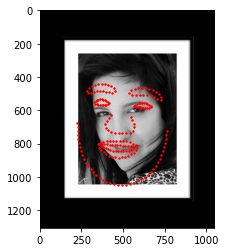

In [77]:
n = 2

fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(Shapes[n][:,0],Shapes[n][:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

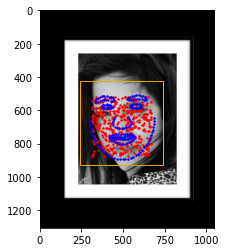

In [59]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(features_0[:,0],features_0[:,1],c='r',s=2)
ax.scatter(S_0[:,0],S_0[:,1],c='b',s=2)
ax.add_patch(Rectangle((bb[0],bb[1]), bb[2], bb[3], ec="orange", fill=None, alpha=1)) 

ax.imshow(test_image,cmap='gray')

In [60]:
cascade0 = np.load("run_output/run_output_model_regression_trees_cascade_0.npy", allow_pickle=True)
initial_contribution = np.load("run_output/run_output_model_f_0_matrix0.npy", allow_pickle=True)

In [61]:
f1,s1 = apply_cascade(S_0, features_0 ,test_image.astype(int), cascade0, initial_contribution)

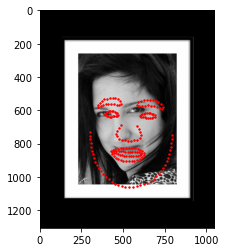

In [62]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s1[:,0],s1[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

In [63]:
cascade1 = np.load("run_output/run_output_model_regression_trees_cascade_1.npy", allow_pickle=True)
initial_contribution1 = np.load("run_output/run_output_model_f_0_matrix1.npy", allow_pickle=True)

In [64]:
f2,s2 = apply_cascade(s1, f1 ,test_image.astype(int), cascade1, initial_contribution1)

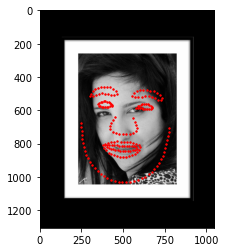

In [65]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s2[:,0],s2[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

In [74]:
cascade2 = np.load("run_output/run_output_model_regression_trees_cascade_2.npy", allow_pickle=True)
initial_contribution2 = np.load("run_output/run_output_model_f_0_matrix2.npy", allow_pickle=True)

In [78]:
len(cascade2)

500

In [75]:
f3,s3 = apply_cascade(s2, f2,test_image.astype(int),cascade2, initial_contribution2)

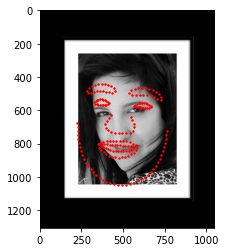

In [76]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s3[:,0],s3[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

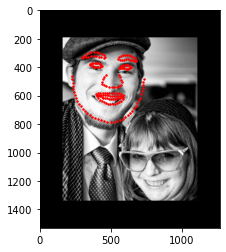

In [158]:
#cascade3 = np.load("run_output/run_output_model_regression_trees_cascade_3.npy", allow_pickle=True)
#initial_contribution3 = np.load("run_output/run_output_model_f_0_matrix3.npy", allow_pickle=True)
f4,s4 = apply_cascade(s3, f3,test_image.astype(int),cascade3, initial_contribution3)

fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s4[:,0],s4[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

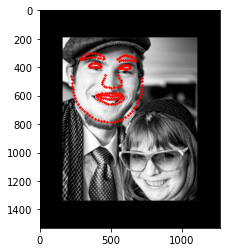

In [159]:
#cascade4 = np.load("run_output/run_output_model_regression_trees_cascade_4.npy", allow_pickle=True)
#initial_contribution4 = np.load("run_output/run_output_model_f_0_matrix4.npy", allow_pickle=True)
f5,s5 = apply_cascade(s4, f4,test_image.astype(int),cascade4, initial_contribution4)

fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s5[:,0],s5[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(test_image,cmap='gray')

In [ ]:
image_num = 10
a0 = training_data[image_num]
a1 = t_0[image_num]
a2 = t_1[image_num]
a3 = t_2[image_num]

In [ ]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
#ax.scatter(a2[1][:,0]  ,a2[1][:,1] ,c='r',s=2)
ax.scatter(a3[1][:,0]  ,a3[1][:,1] ,c='r',s=2)

#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(a0[0],cmap='gray')

In [ ]:
cascade0 = np.load("run_output/run_output_model_regression_trees_cascade_0.npy", allow_pickle=True)
initial_contribution = np.load("run_output/run_output_model_f_0_matrix0.npy", allow_pickle=True)

In [ ]:
f1,s1 = apply_cascade(a0[1],a0[4],np.array(a0[0]).astype(int),cascade0, initial_contribution)

In [ ]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s1[:,0],s1[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(a0[0],cmap='gray')

In [ ]:
cascade1 = np.load("run_output/run_output_model_regression_trees_cascade_1.npy", allow_pickle=True)
initial_contribution1 = np.load("run_output/run_output_model_f_0_matrix1.npy", allow_pickle=True)

In [ ]:
f2,s2 = apply_cascade(s1, f1,np.array(a0[0]).astype(int),cascade1,initial_contribution1)

In [ ]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s2[:,0],s2[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(a0[0],cmap='gray')

In [ ]:
cascade2 = np.load("run_output/run_output_model_regression_trees_cascade_2.npy", allow_pickle=True)
initial_contribution2 = np.load("run_output/run_output_model_f_0_matrix2.npy", allow_pickle=True)

In [ ]:
f3,s3 = apply_cascade(s2, f2,np.array(a0[0]).astype(int),cascade1, initial_contribution1)

In [ ]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s3[:,0],s3[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(a0[0],cmap='gray')

In [ ]:
fig, ax = plt.subplots()
#ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(a2[1][:,0],a2[1][:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(a0[0],cmap='gray')

In [ ]:
annotations_path = 'data/annotation/'

In [ ]:
test_names = get_all_file_names('data/test')

In [ ]:
file = test_names[0]

In [ ]:
I          = np.array(cv2.imread("data/test/" +file, cv2.IMREAD_GRAYSCALE), dtype=np.int32)
h, w       = I.shape
h_pad      = (int((h / 100) * 20))
w_pad      = (int((w / 100) * 20))
I          = cv2.copyMakeBorder(I, h_pad, h_pad, w_pad, w_pad, cv2.BORDER_CONSTANT)
bb         = get_rectangle_bounding_box_for_image("data/test/"+file, frontalface_config='default')

In [ ]:
bb_center_x = bb[0] + w_pad
bb_center_y = bb[1] + h_pad
bb_w        = bb[2]
bb_h        = bb[3]



fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.imshow(I,cmap='gray')


In [ ]:
annotation_files = get_all_file_names(annotations_path)

image_to_annotation_dict = {}
for file in annotation_files:
    with open(annotations_path+file) as f:
        first_line = f.readline().replace('\n','')
    image_to_annotation_dict[first_line] = file

In [ ]:
S_0 = get_mean_shape_from_files(test_names, image_to_annotation_dict,annotations_path)
S_0 = center_shape(S_0)
features_0 = np.load("np_data/mean_shape_features.npy", allow_pickle=True)


In [ ]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_0[:,0],S_0[:,1],c='r',s=2)
ax.scatter(features_0[:,0],features_0[:,1],c='b',s=2)
ax.imshow(I,cmap='gray')

In [ ]:
#NOTE scalling to bb; We choose to multiply s hat height by some constant to make up for the extra padding the bounding box adds
S_0_height      = np.max(S_0[:,1]) - np.min(S_0[:,1])
scale_value            = bb_h / (S_0_height *1.3)
S_0             = S_0 *scale_value
features_0    = features_0 *scale_value

In [ ]:
S_0 += [bb_center_x+bb_w/2,bb_center_y+bb_h/2]
features_0 += [bb_center_x+bb_w/2,bb_center_y+bb_h/2]
features_0 = features_0.astype(int)

In [ ]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_0[:,0],S_0[:,1],c='r',s=2)
ax.scatter(features_0[:,0],features_0[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

In [ ]:
#intensities = I[np.array(features_0[:,1]), np.array(features_0[:,0])]

In [ ]:
#intensities = intensities*0

In [ ]:
f1,s1 = apply_cascade(S_0,features_0,I, cascade0, initial_contribution )

In [ ]:
fig, ax = plt.subplots()
ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(s1[:,0],s1[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

# Running through one cascade 

In [ ]:
cascade0 = np.load("run_output/run_output_model_regression_trees_cascade_0.npy", allow_pickle=True)

In [ ]:
tree = cascade0[0]

In [ ]:
"""count = 0
for node in tree._nodes:
    
    if isinstance(node, Leaf):
        print(node.avarage_residual_vector)
        count +=1 """


In [ ]:
forrest_contribution = np.zeros((388,))

In [ ]:
for tree in cascade0:
    forrest_contribution = forrest_contribution + 0.1* get_avarage_residual_vector_for_image(tree, intensities )

In [ ]:
x_mask = [x for x in range(0, len(forrest_contribution)-1, 2)]
y_mask = [x for x in range(1, len(forrest_contribution), 2)]

In [ ]:
S_1 = S_0 + list(zip(forrest_contribution[x_mask], forrest_contribution[y_mask]))

In [ ]:
fig, ax = plt.subplots()

ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_1[:,0],S_1[:,1],c='r',s=2)
#ax.scatter(features_0[:,0],features_0[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

# Running through many cascades 

In [ ]:
#Calculate means of mean_shape for moving it and its features to origo
S_0_mean       = np.mean(S_0, axis=0)
S_0_centered   = S_0 - S_0_mean
features_0_centered = features_0 - S_0_mean

In [ ]:
#Calculate means of s_hat_new for moving it and its features to origo
S_1_mean = np.mean(S_1, axis=0)
S_1_centered = S_1 - S_1_mean

features_1 = transform_features(S_0_centered, S_1_centered, features_0_centered).astype(int)

#Move features_hat_new back to image's coordinate system
features_1 += S_1_mean.astype(int)

In [ ]:
fig, ax = plt.subplots()

ax.add_patch(Rectangle((bb_center_x,bb_center_y), bb_w, bb_h, ec="orange", fill=None, alpha=1))
ax.scatter(S_1[:,0],S_1[:,1],c='r',s=2)
#ax.scatter(features_1[:,0],features_1[:,1],c='b',s=0.5)
ax.imshow(I,cmap='gray')

In [ ]:
f1, s1 = apply_cascade(S_0, features_0, I, cascade0)